## Step 1. Setup
It takes about one minute \\
(please note that GPU is required)


In [1]:
# @title setup

import os
diffusionclip_dir = os.path.join("/content", "EffDiff")

! git clone https://github.com/omertalmi5/eff-diff-edit $EffDiff_dir

os.chdir(f'./eff-diff-edit')
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

! pip install ftfy regex tqdm
! pip install lmdb
! pip install pynvml
! pip install git+https://github.com/openai/CLIP.git

from utils.colab_utils import GoogleDrive_Dowonloader
from google.colab import auth
download_with_pydrive = True # param {type:"boolean"}
dl = GoogleDrive_Dowonloader(download_with_pydrive)


from effdiff import EffDiff
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
from skimage.io import imread_collection
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2



import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

downloader.download_file('1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn',
                         'pretrained/model_ir_se50.pth')

Cloning into 'eff-diff-edit'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 347 (delta 37), reused 1 (delta 1), pack-reused 271 (from 1)
Receiving objects: 100% (347/347), 21.02 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (141/141), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7k37tog6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7k37tog6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=0b6

Downloading: "https://huggingface.co/gwang-kim/DiffusionCLIP-CelebA_HQ/resolve/main/celeba_hq.ckpt" to /root/.cache/torch/hub/checkpoints/celeba_hq.ckpt
100%|██████████| 434M/434M [00:03<00:00, 140MB/s]


Original diffusion Model loaded.
Setting optimizer with lr=6e-06
Loading losses


100%|███████████████████████████████████████| 335M/335M [00:12<00:00, 28.6MiB/s]
100%|███████████████████████████████████████| 244M/244M [00:07<00:00, 32.1MiB/s]


Uniform skip type
____________________________________________________
['joker.jpg']
runs/single_editing
   ['Hillary Clinton']
-> ['joker.jpg']
Prepare identity latent
precomputed/CelebA_HQ_train_t310_nim1_ninv40_pairs.pth
Done.
Aligned image has shape: (256, 256)
precomputed/CelebA_HQ_test_t310_nim1_ninv40_pairs.pth
Aligned image has shape: (256, 256)
Start finetuning
Sampling type: DDIM with eta 0.0
CHANGE Hillary Clinton TO joker.jpg
Aligned image has shape: (256, 256)
CLIP 0-0: loss_l1: 0.063, loss_clip: 0.651
Training for 1 image(s) takes 3.6673s
Aligned image has shape: (256, 256)
CLIP 0-1: loss_l1: 0.063, loss_clip: 0.586
Training for 1 image(s) takes 1.5221s
Aligned image has shape: (256, 256)
CLIP 0-2: loss_l1: 0.066, loss_clip: 0.515
Training for 1 image(s) takes 1.4688s
Aligned image has shape: (256, 256)
CLIP 0-3: loss_l1: 0.068, loss_clip: 0.495
Training for 1 image(s) takes 1.4489s
Aligned image has shape: (256, 256)
CLIP 0-4: loss_l1: 0.071, loss_clip: 0.475
Training fo

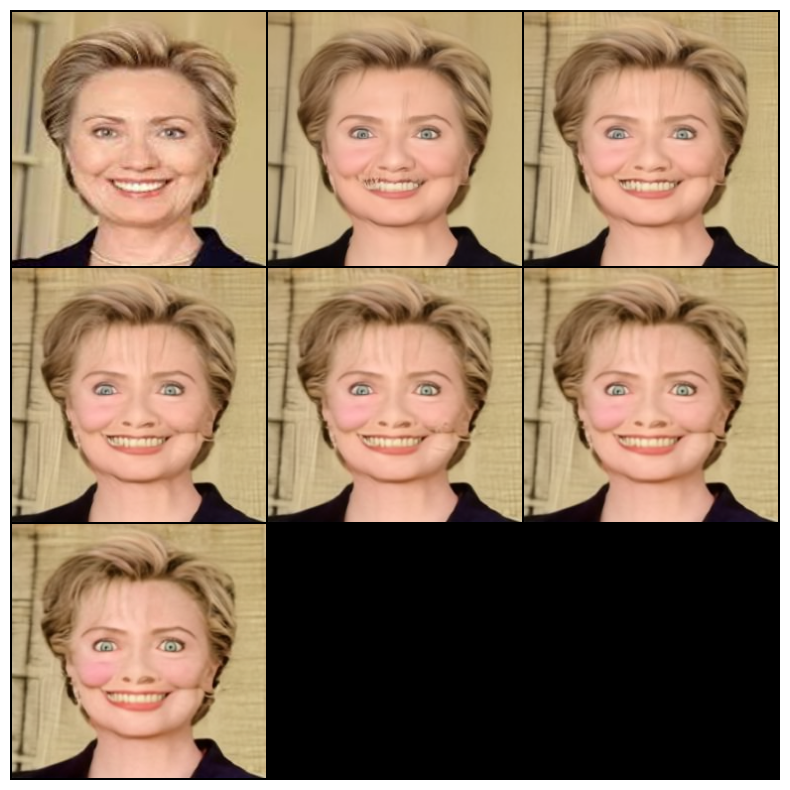

In [2]:
#@title Single image editing

own_image = 'hilery_image.jpg'  #@param {type:"string"}
degree_of_noise = 310 #@param {type:"slider", min:200, max:700, step:10}
config = 'celeba.yml'
source_text = 'Hillary Clinton'  #@param {type:"string"}
ref_image = 'joker.jpg'  #@param {type:"string"}
align_face = "1" #@param [0, 1]
stoshastic_encoding = "1" #@param [0, 1]
training_iterations = 6 #@param {type:"slider", min:1, max:20, step:1}
generation_steps = 4 #@param {type:"slider", min:1, max:6, step:1}
regularization = 2 #@param {type:"slider", min:0, max:10, step:1}

args_dic = {
    'config': 'celeba.yml',
    't_0': degree_of_noise,
    'own_test': own_image,
    'fast_noising_train': int(stoshastic_encoding),
    'fast_noising_test': int(stoshastic_encoding),
    'n_train_step': int(generation_steps),
    'n_test_step': int(generation_steps),
    'own_training': 1,
    'single_image': 1,
    'n_train_img': 1,
    'n_precomp_img': 1,
    'exp': 'runs/single_editing',
    'n_test_img': 1,
    'lr_clip_finetune': 6e-6,
    'model_path': None,
    'l1_loss_w': float(regularization),
    'n_inv_step': int(40),
    'eta': 0.0,
    'sch_gamma': 1.3,
    'number_of_image': 0,
    'sample_type': 'ddim',
    'clip_model_name': 'ViT-B/16',
    'image_folder': 'runs/single_editing/image_samples',
    'n_iter': training_iterations,
    'align_face': int(align_face),
    'src_txts': source_text,
    'trg_image_paths': ref_image,
    'clip_loss_w': 3.0,
    'do_test': 1,
    'id_loss_w': 0.0,
    }

!rm -r precomputed
!rm -r runs
os.makedirs('runs/single_editing/image_samples')
os.makedirs('precomputed', exist_ok=True)

args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = EffDiff(args, config)
runner.clip_finetune()

col_dir = 'runs/single_editing/image_samples/*.png'

col = np.array(imread_collection(col_dir))
batch_tensor = torch.tensor(col).permute(0, 3, 1, 2)
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=3)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))

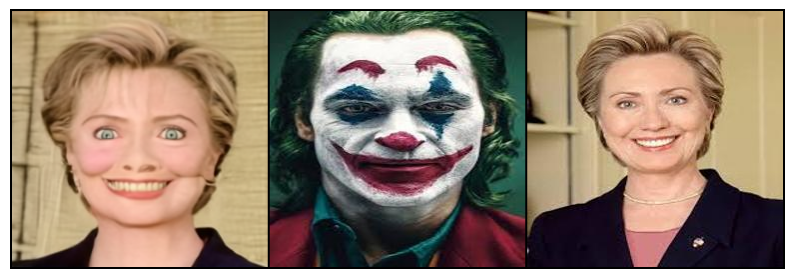

In [3]:
import os
import numpy as np
import torch
import torchvision.utils as tvu
import matplotlib.pyplot as plt
from skimage.io import imread

# Directory containing images for the collection
col_dir = '/content/eff-diff-edit/runs/single_editing/image_samples/'
# Read all images in the collection
image_filenames = [os.path.join(col_dir, fname) for fname in os.listdir(col_dir) if fname.endswith(('.jpg', '.jpeg', '.png'))]
col = np.array([imread(fname) for fname in image_filenames])

# Convert to tensor and permute to (N, C, H, W)
batch_tensor = torch.tensor(col).permute(0, 3, 1, 2).float() / 255.0  # Normalize to [0, 1]

# Load specific images: "joker.jpeg" and "woman.jpg"
joker_img = imread('/content/eff-diff-edit/imgs_for_test/joker.jpg')  # Update with actual path
woman_img = imread('/content/eff-diff-edit/imgs_for_test/hilery_image.jpg')  # Update with actual path

# Convert these to tensors
joker_tensor = torch.tensor(joker_img).permute(2, 0, 1).float() / 255.0  # Normalize to [0, 1]
woman_tensor = torch.tensor(woman_img).permute(2, 0, 1).float() / 255.0  # Normalize to [0, 1]

# Extract the last image from the batch
last_img_tensor = batch_tensor[0]

# Create a combined tensor of the three images
combined_tensor = torch.stack([last_img_tensor, joker_tensor, woman_tensor])

# Create a grid of images
grid_img = tvu.make_grid(combined_tensor, nrow=3)

# Display the grid
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))  # Convert to (H, W, C) for visualization
plt.show()
